<h1><center><span style="color: red;">MINI PROJECT - PREDICTION OF BRIDGE CONDITION</span></center></h1>

<h3> Load necessary libraries </h3>

In [1]:
# For Operating system dependent functionality
import os 

# For data structures like series and dataframe
import pandas as pd

# For numerical computing
import numpy as np

# For handling geospatial dataframe
import geopandas as gpd

# For splitting a dataset into training and testing subsets
from sklearn.model_selection import train_test_split

# For creating interactive visualizations in Python.
import matplotlib.pyplot as plt

#Alias of Map Utils like 'plt' for plot. For North Arrow.
import matplotlib_map_utils as mapu 

#  Imports the LogisticRegression class from the sklearn.linear_model module.
from sklearn.linear_model import LogisticRegression

# For assessing the quality and performance of machine learning classification models.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from shapely.geometry import Point

<h3> Set and change the path of a directory </h3>

In [2]:
# Set path for the working directory
path = r'C:\Users\Prabin-PC\Downloads\MINIPROJECT' # adding an r before the string tells Python to treat backslashes as literal characters.

# Changing the directory to path
os.chdir(path)

<h3> Read the dataframes </h3> 

In [28]:
# Read the dataframes year 2022 and 2023
# National bridge inventory data (NBI) that is available at: https://www.fhwa.dot.gov/bridge/nbi.cfm

TX22 = pd.read_csv('TX22.csv', low_memory=False)
TX23 = pd.read_csv('TX23.csv', low_memory=False)
# This option allows Pandas to process the file in chunks, which can help it infer data types more accurately.

<h3> Identification of Unique Bridge Structures in TX23 Dataset </h3>  
 In this step, the project aims to identify unique bridge structures present in the TX23 dataset that are not found in the TX22 dataset. 

In [4]:
# Get the STRUCTURE_NUMBER_008 values that are present in TX22
common_structure_numbers = TX22['STRUCTURE_NUMBER_008'].unique()

# Create TX23_unique by filtering TX23 for rows with STRUCTURE_NUMBER_008 not in TX22
TX23_unique = TX23[~TX23['STRUCTURE_NUMBER_008'].isin(common_structure_numbers)]

# Optionally, reset the index for clarity
TX23_unique.reset_index(drop=True, inplace=True)

       STATE_CODE_001 STRUCTURE_NUMBER_008  RECORD_TYPE_005A  \
0                  48      000021594-62610                 1   
1                  48                1E+13                 1   
2                  48          1.06001E+13                 1   
3                  48          1.06001E+13                 1   
4                  48          1.06001E+13                 1   
...               ...                  ...               ...   
35429              48      DAPFORHOO0BVM20                 1   
35430              48      NCA1                            1   
35431              48      NCA2                            1   
35432              48      NCA3                            1   
35433              48      NCA6                            1   

       ROUTE_PREFIX_005B  SERVICE_LEVEL_005C ROUTE_NUMBER_005D  \
0                      6                   0                 0   
1                      6                   0               217   
2                      3         

<h3>Function for Converting DMS to Decimal Degrees</h3>
This function is particularly useful for converting geographic coordinates for further spatial analysis, ensuring that the data is in a format suitable for mapping and geographic information system (GIS) applications.

In [9]:
# Function to convert DMS to Decimal Degrees
def dms_to_dd(dms_value, is_latitude=True):
    try:
        # Extract degrees, minutes, and seconds
        degrees = int(dms_value / 1000000)
        minutes = int((dms_value - degrees * 1000000) / 10000)
        seconds = (dms_value - degrees * 1000000 - minutes * 10000) / 100
        
        # Calculate decimal degrees
        decimal_degrees = degrees + (minutes / 60) + (seconds / 3600)
        
        # Return positive or negative based on latitude
        return decimal_degrees if is_latitude else -decimal_degrees

    except Exception as e:
        print(f"Error in conversion: {e}")
        return None


<h3> Applying the conversion </h3>
The DMS values in the LAT_016 and LONG_017 column are converted to Decimal Degrees and stored in a new column LAT_016_dd and LONG_017_dd. The is_latitude flag is set to True for this conversion.

In [10]:
# Convert Latitude and Longitude from DMS to Decimal Degrees
TX23_unique.loc[:, 'LAT_016_dd'] = TX23['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
TX23_unique.loc[:, 'LONG_017_dd'] = TX23['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))

C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\1900743436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX23_unique.loc[:, 'LAT_016_dd'] = TX23['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\1900743436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX23_unique.loc[:, 'LONG_017_dd'] = TX23['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))


<h2><span style="color: red;">Creating a GeoDataFrame and Plotting Geographic Data </span></h2> 
This process visualizes the locations of bridges that were surveyed in 2023 but were not part of the 2022 survey, providing insights into infrastructure changes over time.

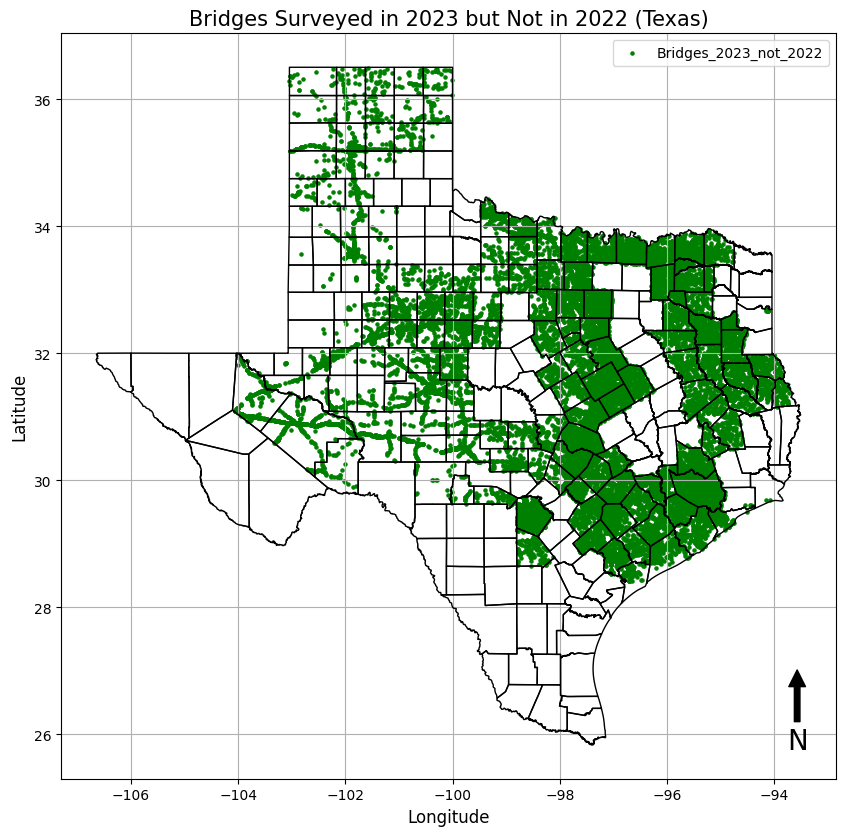

In [11]:
# Create a GeoDataFrame with the converted coordinates
geometry = [Point(xy) for xy in zip(TX23_unique['LONG_017_dd'], TX23_unique['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(TX23_unique, geometry=geometry)

# Set the initial CRS to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Reproject to NAD83
gdf = gdf.to_crs(epsg=4269)

# Load the map, specifying the layer name if there are multiple
Map = gpd.read_file(r'C:\Users\Prabin-PC\Downloads\MINIPROJECT\TexasMap.gpkg')

# Ensure map is in EPSG:4269
if Map.crs.to_epsg() != 4269:
    Map = Map.to_crs(epsg=4269)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
Map.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot the bridges
gdf.plot(ax=ax, color='green', marker='o', markersize=5, label='Bridges_2023_not_2022')

# Add north arrow
x, y, arrow_length = 0.95, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')


# Customize the map
ax.set_title('Bridges Surveyed in 2023 but Not in 2022 (Texas)', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()  

<h3> Converting the data types </h3>
The line of code you provided is transforming a DataFrame TX22 by applying a function to specific columns and converting their values to numeric data types. 

In [12]:
TX22=TX22.apply(pd.to_numeric, errors='coerce')

<h3>Selecting columns to modify for dataframe TX22 and TX23_unique </h3>
This process converts specific condition values within designated columns into a binary format (0 or 1), enhancing the dataset's usability for subsequent analysis or modeling tasks, such as logistic regression.

In [13]:
TX23_unique=TX23_unique.apply(pd.to_numeric, errors='coerce')
# List of columns to modify
columns_to_modify = ['CULVERT_COND_062', 'DECK_COND_058', 'CHANNEL_COND_061']

# Apply the transformation to each of the specified columns
TX23_unique[columns_to_modify] = TX23_unique[columns_to_modify].applymap(lambda x: 1 if x >= 6 else 0)

C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\3962012947.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TX23_unique[columns_to_modify] = TX23_unique[columns_to_modify].applymap(lambda x: 1 if x >= 6 else 0)


In [14]:
# List of columns to modify
columns_to_modify = ['CULVERT_COND_062', 'DECK_COND_058', 'CHANNEL_COND_061']

# Apply the transformation to each of the specified columns
TX22[columns_to_modify] = TX22[columns_to_modify].applymap(lambda x: 1 if x >= 6 else 0)

C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\268689548.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TX22[columns_to_modify] = TX22[columns_to_modify].applymap(lambda x: 1 if x >= 6 else 0)


<h3>Creation of Subset DataFrames</h3>
These subset DataFrames will facilitate targeted analyses and modeling tasks, enabling you to evaluate bridge conditions and related factors effectively.

In [15]:
# Specify the columns to process
selected_columns_deck = [
    'ADT_029', 'SURFACE_TYPE_108A', 'MAINTENANCE_021', 
    'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 
    'STRUCTURE_TYPE_043B' , 
    'DECK_COND_058', 'CHANNEL_COND_061', 'LONG_017', 'LAT_016'
]


selected_columns_culvert = [
    'ADT_029', 'SURFACE_TYPE_108A', 'MAINTENANCE_021', 
    'STRUCTURE_TYPE_043B', 
    'CULVERT_COND_062', 'LONG_017', 'LAT_016'
]


selected_columns_channel = [
    'ADT_029', 'SURFACE_TYPE_108A', 'MAINTENANCE_021', 
    'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 
    'STRUCTURE_TYPE_043B', 
    'DECK_COND_058', 'CHANNEL_COND_061', 'LONG_017', 'LAT_016'
]

In [16]:
TX22_only_deck=TX22[selected_columns_deck]
TX23_unique_only_deck=TX23_unique[selected_columns_deck]

TX22_only_culvert=TX22[selected_columns_culvert]
TX23_unique_only_culvert=TX23_unique[selected_columns_culvert]

TX22_only_channel=TX22[selected_columns_channel]
TX23_unique_only_channel=TX23_unique[selected_columns_channel]

<h3>Handling Missing Data</h3>
In both TX22_only_deck and TX23_unique_only_deck, all occurrences of the string "N" have been replaced with NaN (Not a Number). This step is essential for data cleaning, as the presence of the string "N" may indicate missing or unavailable information regarding bridge conditions.

In [17]:
TX22_only_deck.replace("N", np.nan, inplace=True)
TX23_unique_only_deck.replace("N", np.nan, inplace=True)

TX22_only_culvert.replace("N", np.nan, inplace=True)
TX23_unique_only_culvert.replace("N", np.nan, inplace=True)

TX22_only_channel.replace("N", np.nan, inplace=True)
TX23_unique_only_channel.replace("N", np.nan, inplace=True)

C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\1673239811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX22_only_deck.replace("N", np.nan, inplace=True)
C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\1673239811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TX23_unique_only_deck.replace("N", np.nan, inplace=True)
C:\Users\Prabin-PC\AppData\Local\Temp\ipykernel_21368\1673239811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

<h3>Data Cleaning and Subset Selection for Culvert, Channel and Deck Condition Analysis</h3>
In both TX22_only and TX23_unique missing values (NaN) have been dropped. The new DataFrame TX22_only and TX23_unique will only include the columns listed in selected_columns. This will isolate the culvert-related features for further analysis or modeling.

In [18]:
# Drop rows where 'DECK_COND_058' or 'CHANNEL_COND_061' are missing
TX22_only_deck = TX22_only_deck.dropna()
TX23_unique_only_deck = TX23_unique_only_deck.dropna()

# Drop rows where 'CULVERT_COND_62' are missing
TX22_only_culvert = TX22_only_culvert.dropna()
TX23_unique_only_culvert = TX23_unique_only_culvert.dropna()

# Drop rows where 'DECK_COND_058' or 'CHANNEL_COND_061' are missing
TX22_only_channel = TX22_only_channel.dropna()
TX23_unique_only_channel = TX23_unique_only_deck.dropna()

<h2><span style="color: red;">Logistic Regression Analysis of Deck Conditions in Bridges: Performance Evaluation</span></h2>
This code implements a logistic regression model to predict the deck condition of bridges based on specific features. The analysis is conducted using training data from the TX22_only_deck DataFrame and evaluated against the TX23_unique_only_deck dataset.

In [19]:
features_deck=['ADT_029', 'SURFACE_TYPE_108A', 'MAINTENANCE_021', 
    'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 
    'STRUCTURE_TYPE_043B']

target=['DECK_COND_058']

# Split the data into training and testing sets
X_train= TX22_only_deck[features_deck]
y_train= TX22_only_deck[target]


# Create the logistic regression model
model = LogisticRegression()


# Fit the model
model.fit(X_train, y_train)

TX23_unique_only_deck = TX23_unique_only_deck.astype(int)
X_test = TX23_unique_only_deck[features_deck]
y_test = TX23_unique_only_deck[target]


# Make predictions using the trained model
y_predict_deck = model.predict(X_test)


# Generate the classification report
TX23_accuracy = accuracy_score(y_test, y_predict_deck)
TX23_confusion = confusion_matrix(y_test, y_predict_deck)
TX23_report = classification_report(y_test, y_predict_deck)


print(f'Accuracy: {TX23_accuracy}')
print('Confusion Matrix:\n', TX23_confusion)
print('Classification Report:\n', TX23_report)

C:\Users\Prabin-PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9648289849728036
Confusion Matrix:
 [[    2   763]
 [    0 20929]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01       765
           1       0.96      1.00      0.98     20929

    accuracy                           0.96     21694
   macro avg       0.98      0.50      0.49     21694
weighted avg       0.97      0.96      0.95     21694



C:\Users\Prabin-PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<h3><span style="color: blue;">Visualization of Predicted vs Actual Bridge Conditions Using Geographic Mapping for Deck Condition</span></h3>

This code converts geographic coordinates from Degrees, Minutes, and Seconds (DMS) to Decimal Degrees for latitude and longitude. It then creates a GeoDataFrame containing prediction results from a logistic regression model. The predicted and actual bridge conditions are compared, and points are color-coded on a map: green for correct predictions and red for incorrect ones.

In [20]:
# Convert Latitude and Longitude from DMS to Decimal Degrees
TX23_unique_only_deck.loc[:, 'LAT_016_dd'] = TX23['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
TX23_unique_only_deck.loc[:, 'LONG_017_dd'] = TX23['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))

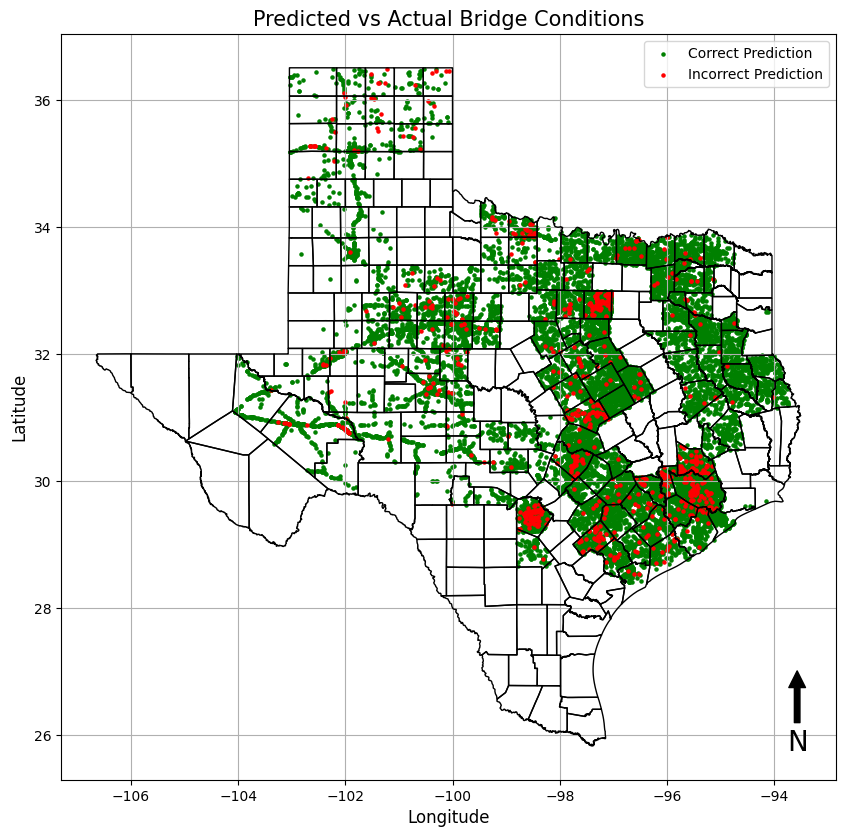

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming y_test is a DataFrame; convert it to a Series first
y_test = TX23_unique_only_deck[target].values.flatten()  # Flatten the target array

# Creating the Geo DataFrame
TX23_unique_only_deck['Predicted'] = y_predict_deck.flatten()  # Ensure it's 1D
TX23_unique_only_deck['Actual'] = y_test  # Now y_test is already flattened

# Create a new column for color based on correctness
TX23_unique_only_deck['Color'] = TX23_unique_only_deck.apply(
    lambda row: 'green' if row['Predicted'] == row['Actual'] else 'red', axis=1)

# Create geometry for the GeoDataFrame
geometry = [Point(xy) for xy in zip(TX23_unique_only_deck['LONG_017_dd'], TX23_unique_only_deck['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(TX23_unique_only_deck, geometry=geometry)

# Set the CRS to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Load the base map
# Map = gpd.read_file('path_to_your_geopackage')

# Ensure map is in EPSG:4269 (if needed)
# if Map.crs.to_epsg() != 4269:
#     Map = Map.to_crs(epsg=4269)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
Map.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot points based on color condition
gdf[gdf['Color'] == 'green'].plot(ax=ax, color='green', marker='o', markersize=5, label='Correct Prediction')
gdf[gdf['Color'] == 'red'].plot(ax=ax, color='red', marker='o', markersize=5, label='Incorrect Prediction')

# Add north arrow
x, y, arrow_length = 0.95, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Customize the map
ax.set_title('Predicted vs Actual Bridge Conditions', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


<h2><span style="color: red;">Logistic Regression Analysis of Culvert Conditions in Bridges: Performance Evaluation</span></h2>
This code implements a logistic regression model to predict the Culvert condition of bridges based on specific features. The analysis is conducted using training data from the TX22_only_Culvert DataFrame and evaluated against the TX23_unique_only_Culvert dataset.

In [22]:
features_culvert=['ADT_029', 'SURFACE_TYPE_108A', 'MAINTENANCE_021', 
                  'STRUCTURE_TYPE_043B']

target=['CULVERT_COND_062']

# Split the data into training and testing sets
X_train= TX22_only_culvert[features_culvert]
y_train= TX22_only_culvert[target]


# Create the logistic regression model
model = LogisticRegression()


# Fit the model
model.fit(X_train, y_train)

TX23_unique_only_culvert = TX23_unique_only_culvert.astype(int)
X_test = TX23_unique_only_culvert[features_culvert]
y_test = TX23_unique_only_culvert[target]

# Make predictions using the trained model
y_predict_culvert = model.predict(X_test)

# Generate the classification report
TX23_accuracy = accuracy_score(y_test, y_predict_culvert)
TX23_confusion = confusion_matrix(y_test, y_predict_culvert)
TX23_report = classification_report(y_test, y_predict_culvert)


print(f'Accuracy: {TX23_accuracy}')
print('Confusion Matrix:\n', TX23_confusion)
print('Classification Report:\n', TX23_report)

C:\Users\Prabin-PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9861345260622743
Confusion Matrix:
 [[21631   397]
 [    6  7031]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     22028
           1       0.95      1.00      0.97      7037

    accuracy                           0.99     29065
   macro avg       0.97      0.99      0.98     29065
weighted avg       0.99      0.99      0.99     29065



C:\Users\Prabin-PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<h3><span style="color: blue;">Visualization of Predicted vs Actual Bridge Conditions Using Geographic Mapping for Culvert Condition</span></h3>

This code converts geographic coordinates from Degrees, Minutes, and Seconds (DMS) to Decimal Degrees for latitude and longitude. It then creates a GeoDataFrame containing prediction results from a logistic regression model. The predicted and actual bridge conditions are compared, and points are color-coded on a map: green for correct predictions and red for incorrect ones.1

In [23]:
# Convert Latitude and Longitude from DMS to Decimal Degrees
TX23_unique_only_culvert.loc[:, 'LAT_016_dd'] = TX23['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
TX23_unique_only_culvert.loc[:, 'LONG_017_dd'] = TX23['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))

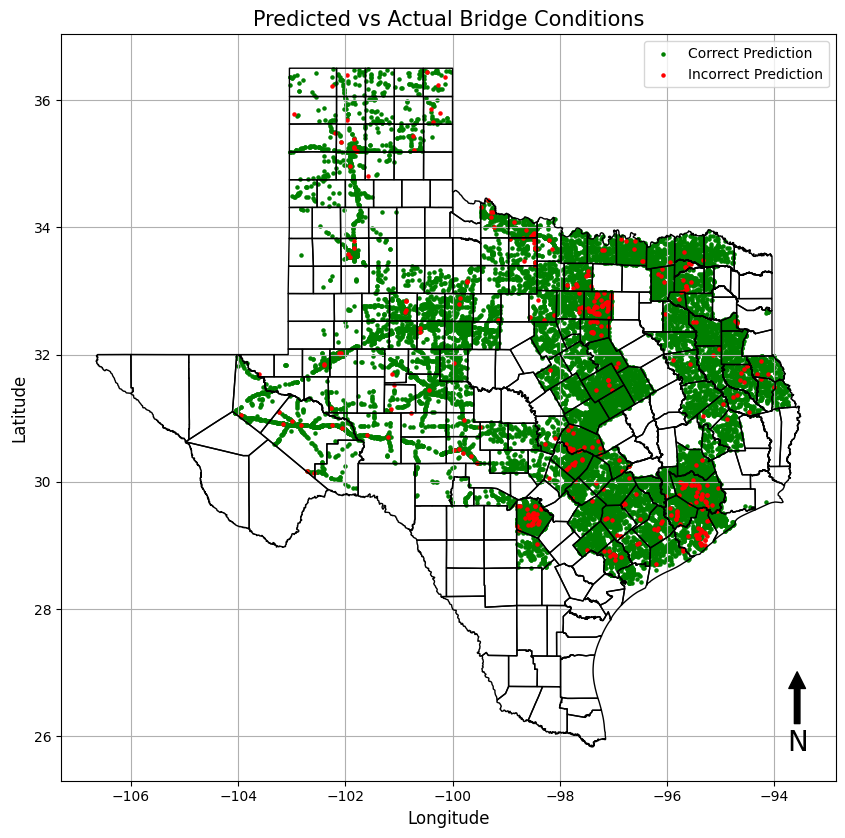

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming y_test is a DataFrame; convert it to a Series first
y_test = TX23_unique_only_culvert[target].values.flatten()  # Flatten the target array

# Creating the Geo DataFrame
TX23_unique_only_culvert['Predicted'] = y_predict_culvert.flatten()  # Ensure it's 1D
TX23_unique_only_culvert['Actual'] = y_test  # Now y_test is already flattened

# Create a new column for color based on correctness
TX23_unique_only_culvert['Color'] = TX23_unique_only_culvert.apply(
    lambda row: 'green' if row['Predicted'] == row['Actual'] else 'red', axis=1)

# Create geometry for the GeoDataFrame
geometry = [Point(xy) for xy in zip(TX23_unique_only_culvert['LONG_017_dd'], TX23_unique_only_culvert['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(TX23_unique_only_culvert, geometry=geometry)

# Set the CRS to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Load the base map
# Map = gpd.read_file('path_to_your_geopackage')

# Ensure map is in EPSG:4269 (if needed)
# if Map.crs.to_epsg() != 4269:
#     Map = Map.to_crs(epsg=4269)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
Map.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot points based on color condition
gdf[gdf['Color'] == 'green'].plot(ax=ax, color='green', marker='o', markersize=5, label='Correct Prediction')
gdf[gdf['Color'] == 'red'].plot(ax=ax, color='red', marker='o', markersize=5, label='Incorrect Prediction')

# Add north arrow
x, y, arrow_length = 0.95, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Customize the map
ax.set_title('Predicted vs Actual Bridge Conditions', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


<h2><span style="color: red;">Logistic Regression Analysis of Channel Conditions in Bridges: Performance Evaluation</span></h2>
This code implements a logistic regression model to predict the Channel condition of bridges based on specific features. The analysis is conducted using training data from the TX22_only_channel DataFrame and evaluated against the TX23_unique_only_channel dataset.

In [25]:
features_channel=['ADT_029', 'SURFACE_TYPE_108A', 'MAINTENANCE_021', 
    'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 
    'STRUCTURE_TYPE_043B']

target=['CHANNEL_COND_061']

# Split the data into training and testing sets
X_train = TX22_only_channel[features_channel]  
y_train = TX22_only_channel[target]


# Create the logistic regression model
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

TX23_unique_only_channel = TX23_unique_only_channel.astype(int)
X_test = TX23_unique_only_channel[features_channel]
y_test = TX23_unique_only_channel[target]

# Make predictions
y_predict_channel = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_predict_channel)
confusion = confusion_matrix(y_test, y_predict_channel)
report = classification_report(y_test, y_predict_channel)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', report)

C:\Users\Prabin-PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6314188254817
Confusion Matrix:
 [[ 2946  6966]
 [ 1030 10752]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.30      0.42      9912
           1       0.61      0.91      0.73     11782

    accuracy                           0.63     21694
   macro avg       0.67      0.60      0.58     21694
weighted avg       0.67      0.63      0.59     21694



C:\Users\Prabin-PC\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<h3><span style="color: blue;">Visualization of Predicted vs Actual Bridge Conditions Using Geographic Mapping for Channel Condition</span></h3>

This code converts geographic coordinates from Degrees, Minutes, and Seconds (DMS) to Decimal Degrees for latitude and longitude. It then creates a GeoDataFrame containing prediction results from a logistic regression model. The predicted and actual bridge conditions are compared, and points are color-coded on a map: green for correct predictions and red for incorrect ones.

In [26]:
# Convert Latitude and Longitude from DMS to Decimal Degrees
TX23_unique_only_channel.loc[:, 'LAT_016_dd'] = TX23['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
TX23_unique_only_channel.loc[:, 'LONG_017_dd'] = TX23['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))

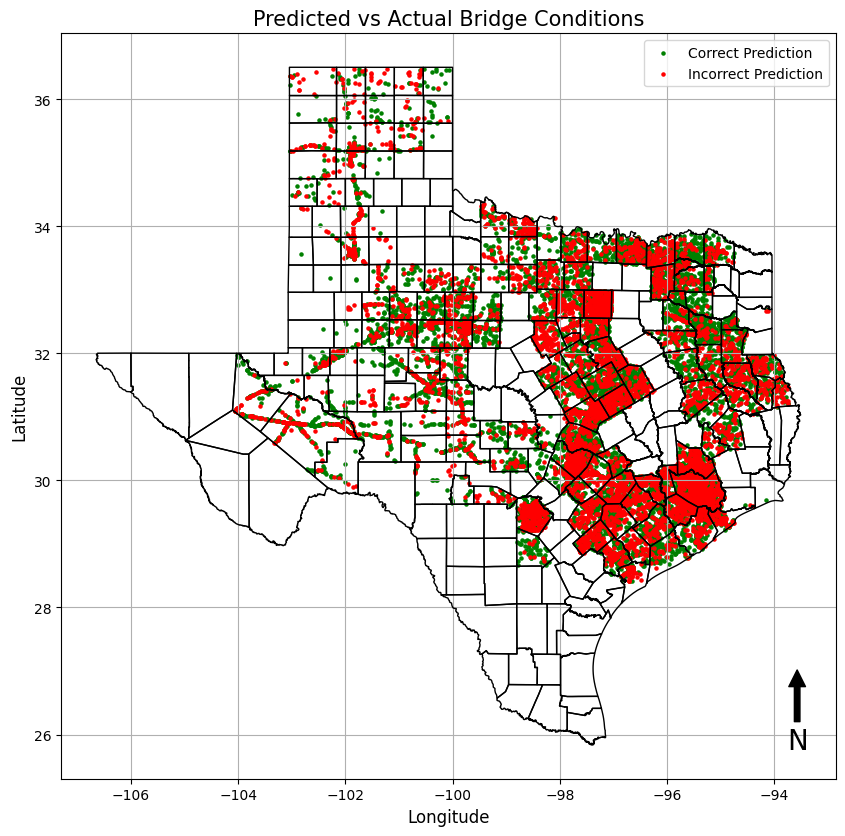

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Assuming y_test is a DataFrame; convert it to a Series first
y_test = TX23_unique_only_channel[target].values.flatten()  # Flatten the target array

# Creating the Geo DataFrame
TX23_unique_only_channel['Predicted'] = y_predict_channel.flatten()  # Ensure it's 1D
TX23_unique_only_channel['Actual'] = y_test  # Now y_test is already flattened

# Create a new column for color based on correctness
TX23_unique_only_channel['Color'] = TX23_unique_only_channel.apply(
    lambda row: 'green' if row['Predicted'] == row['Actual'] else 'red', axis=1)

# Create geometry for the GeoDataFrame
geometry = [Point(xy) for xy in zip(TX23_unique_only_channel['LONG_017_dd'], TX23_unique_only_channel['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(TX23_unique_only_channel, geometry=geometry)

# Set the CRS to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Load the base map
# Map = gpd.read_file('path_to_your_geopackage')

# Ensure map is in EPSG:4269 (if needed)
# if Map.crs.to_epsg() != 4269:
#     Map = Map.to_crs(epsg=4269)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
Map.boundary.plot(ax=ax, linewidth=1, color='black')

# Plot points based on color condition
gdf[gdf['Color'] == 'green'].plot(ax=ax, color='green', marker='o', markersize=5, label='Correct Prediction')
gdf[gdf['Color'] == 'red'].plot(ax=ax, color='red', marker='o', markersize=5, label='Incorrect Prediction')

# Add north arrow
x, y, arrow_length = 0.95, 0.15, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Customize the map
ax.set_title('Predicted vs Actual Bridge Conditions', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


<h2>Detailed Project Summary</h2> 
This project involves a comprehensive analysis of bridge conditions using logistic regression, focusing on culverts, channels, and deck conditions. The analysis is conducted using two datasets: TX22 and TX23. Below is a detailed breakdown of each step undertaken in the project:

**1. Data Selection**
Identifying Unique Bridges: The first step involved identifying bridges that are present in the TX23 dataset but absent in the TX22 dataset. This ensured that the analysis focused on the most current and relevant data. 

National bridge inventory data (NBI) that is available at: https://www.fhwa.dot.gov/bridge/nbi.cfm

**2. Coordinate Conversion**
Longitude and Latitude Conversion: The geographic coordinates were initially stored in 8-digit values. These were converted into Decimal Degrees to facilitate accurate mapping and analysis of the bridge locations. This conversion enhances the usability of the coordinates in geographic information systems (GIS).

**3. Data Cleaning**
Handling Missing Values: Entries containing 'N' values were replaced with NaN (Not a Number), and these rows were subsequently dropped from the dataset. This cleaning process is crucial for maintaining data integrity, as missing values can significantly skew the results of the analysis.

**4. Feature Selection**
A careful selection of features was made to ensure the model could effectively predict the conditions of bridges. The selected features are:
ADT_029: Average Daily Traffic
SURFACE_TYPE_108A: Type of Surface
MAINTENANCE_021: Maintenance History
SUPERSTRUCTURE_COND_059: Superstructure Condition
SUBSTRUCTURE_COND_060: Substructure Condition
STRUCTURE_TYPE_043B: Structure Type
The target variables included:
DECK_COND_058: Deck Condition
CHANNEL_COND_061 : Channel Condition
CULVERT_COND_060 : Culvert Condition

**5. Predictive Modeling**

Logistic Regression:

Logistic regression models were created to predict the conditions of the bridges based on the selected features. This statistical method is suitable for binary classification tasks, allowing the prediction of whether a bridge condition falls into one of the defined categories (e.g., acceptable or poor).

Condition Categorization:

A lambda function was employed to categorize the condition values:
Values less than 5 were mapped to 0, indicating a poor condition.
Values between 5 and 9 were mapped to 1, indicating an acceptable condition.

Training and Testing:

The models were trained on the cleaned TX22 dataset, which served as the historical data for the bridge conditions. The TX23 dataset was then used for testing the trained models, allowing for the evaluation of their predictive performance.

**6. Performance Evaluation**

Accuracy and Precision Metrics:

The performance of the models was evaluated using key metrics, including accuracy, precision, and recall for each of the three conditions (culvert, channel, and deck). These metrics provide insights into the models' ability to correctly classify the conditions based on the input features.
Confusion matrices and classification reports were generated to give a detailed view of the model's performance, helping to identify strengths and weaknesses in the predictions.

**7. Visualization**

Geographic Mapping:

Separate geographic maps were created for the predicted conditions of culverts, channels, and decks. The visualization utilized:
Green dots to represent correct predictions (where the predicted condition matched the actual condition).
Red dots to indicate incorrect predictions (where the predicted condition differed from the actual condition).
This mapping not only visually summarizes the predictive performance but also highlights areas requiring attention for bridge maintenance and repair.

<h2>Conclusion</h2> 

Overall, this project showcases a robust methodology for analyzing and predicting bridge conditions using logistic regression, supported by thorough data preparation and visualization techniques. The insights gained from this analysis are crucial for infrastructure management, helping stakeholders prioritize maintenance activities based on predictive outcomes. By integrating data science with geographic visualization, the project enhances decision-making processes in bridge management and safety assessments.